In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from time import time
import random

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# data exploration

In [2]:
data = pd.read_csv('bank_data_prediction_task.csv', index_col = 0)

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
data.iloc[:5, :15]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome
1,37,services,married,high.school,no,yes,no,telephone,may,mon,226.0,1.0,999,0,nonexistent
2,56,services,married,high.school,no,no,yes,telephone,may,mon,307.0,1.0,999,0,nonexistent
3,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217.0,1.0,999,0,nonexistent
4,25,services,single,high.school,no,yes,no,telephone,may,mon,50.0,1.0,999,0,nonexistent
5,25,services,single,high.school,no,yes,no,telephone,may,mon,222.0,1.0,999,0,nonexistent


In [11]:
data.iloc[:5, 15:]

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,test_control_flag
1,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
2,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
3,1.1,93.994,-36.4,4.857,5191.0,yes,campaign group
4,1.1,93.994,-36.4,4.857,5191.0,no,campaign group
5,1.1,93.994,-36.4,4.857,5191.0,no,campaign group


In [9]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'test_control_flag'],
      dtype='object')

Explanations of some terms:  
emp.var.rate- how big is a change in employement (how many people get hired or fired)  
consumer price index - how big is a change in how much money customers spend  
consumer confidence index- how pesimistic or optimistic people are about their financial situation in the nearest future  
euribor 3 month rate- 3 month rate at which banks borrow funds in euros from one another. If this rate is low then then people pay less for their loans so it is beneficial for them.

calculating chi squared. If chi squared is smaller than 0.05 then given feature is correlated with the 'y' variable

In [12]:
ChiSqResults = []

for column in [
    'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'month', 'day_of_week', 'duration', 'campaign','poutcome'
]:
    CrosstabResult = pd.crosstab(index = data[column], columns = data['y'])
    ChiSqResults.append([column, chi2_contingency(CrosstabResult)[1]])
    
df = pd.DataFrame(ChiSqResults, columns = ['feature', 'chi_squared'])
df.sort_values(by = 'chi_squared')

,feature,chi_squared
12,poutcome,0.000000e+00
10,duration,7.992084e-247
0,age,3.334413e-232
1,job,2.777061e-144
8,month,3.802114e-115
4,default,9.439545e-70
2,marital,2.397748e-59
7,contact,2.220714e-36
3,education,3.935600e-18
6,loan,2.440140e-03


calculating correlation for numerical variables

In [50]:
corr = np.array([])
for column in [
    'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
    'cons.conf.idx', 'euribor3m', 'nr.employed'
]:
    df = data[[column, 'y']].dropna()
    y = df['y'].apply(lambda x: 1 if x == 'yes' else 0).values
    x = df[column].values
    if len(corr) == 0:
        corr = np.array([[column, np.corrcoef(x, y)[0,1]]])
    else:
        corr = np.concatenate((corr, [[column, np.corrcoef(x, y)[0,1]]]), axis = 0)

In [51]:
pd.DataFrame(corr, columns = ['feature', 'correlation_with_y']).sort_values(by = 'correlation_with_y')

,feature,correlation_with_y
3,cons.price.idx,-0.11191057015917759
2,emp.var.rate,-0.255561940750331
5,euribor3m,-0.2651695899608683
0,pdays,-0.2807193683123893
6,nr.employed,-0.3066371412555699
4,cons.conf.idx,0.044016678896950295
1,previous,0.20543292917077963


It looks like all the variables are correlated with the 'y' variable except for 'day_of_week', 'cons.conf.idx' and 'cons.price.idx'

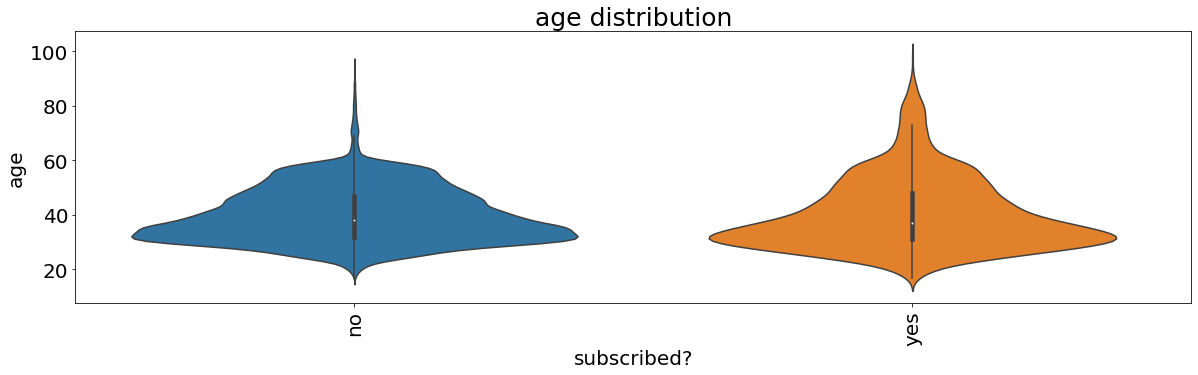

In [122]:
fig, ax = plt.subplots(figsize = (20, 5))
sns.violinplot(data = data, y = 'age', x = 'y')
plt.xticks(rotation=90)
plt.title('age distribution', fontsize = 25)
plt.ylabel('age', fontsize = 20)
plt.xlabel('subscribed?', fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


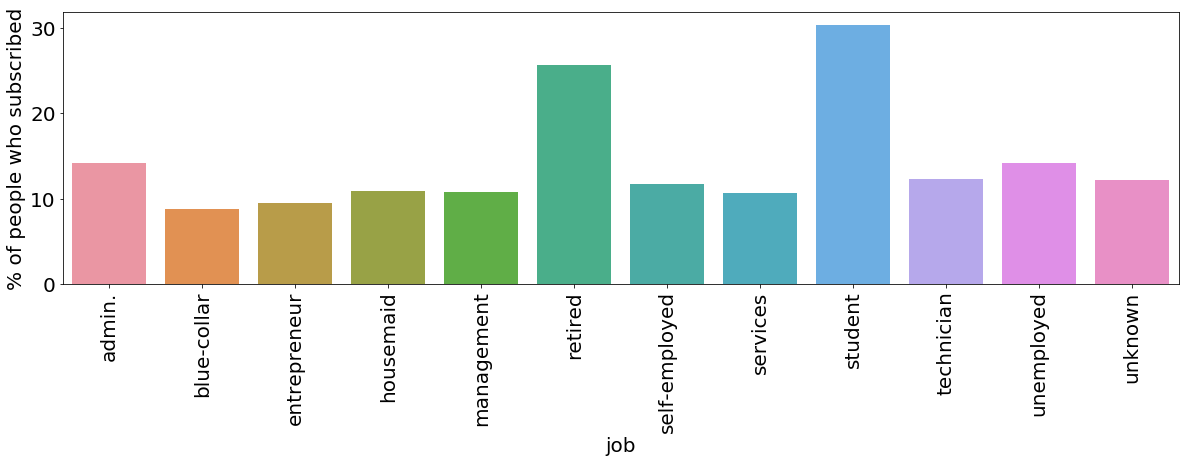

In [151]:
column = 'job'

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


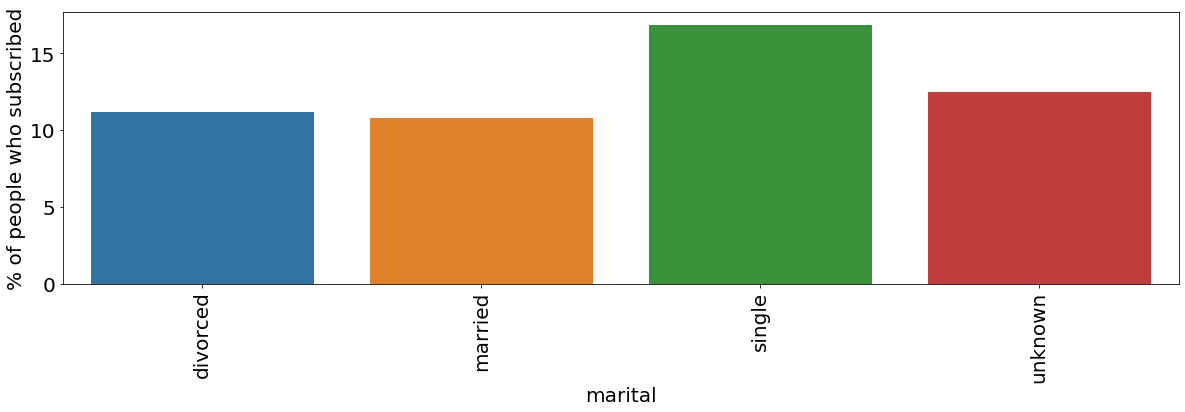

In [152]:
column = 'marital'

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


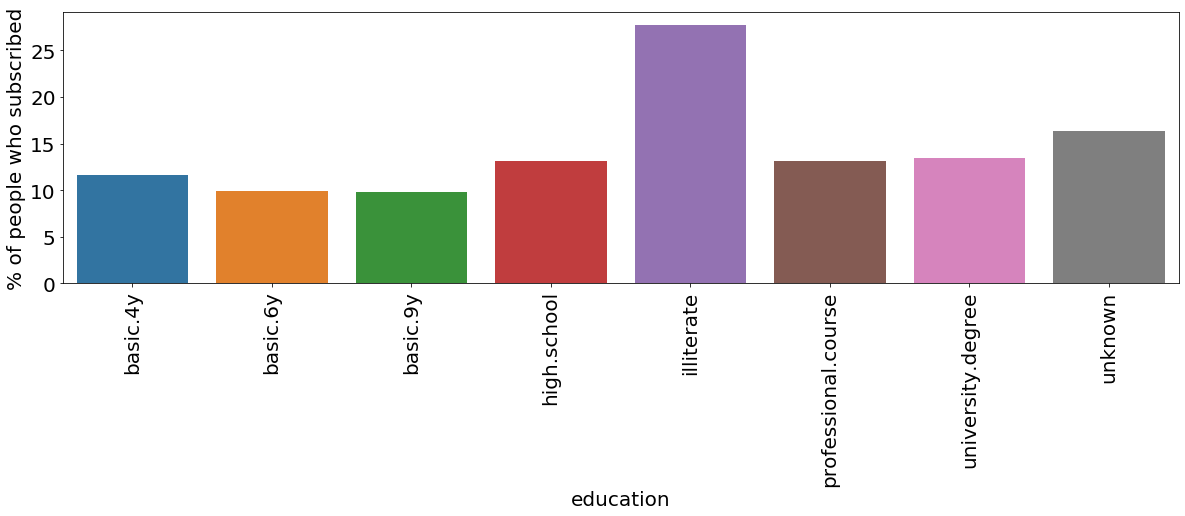

In [153]:
column = 'education'

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


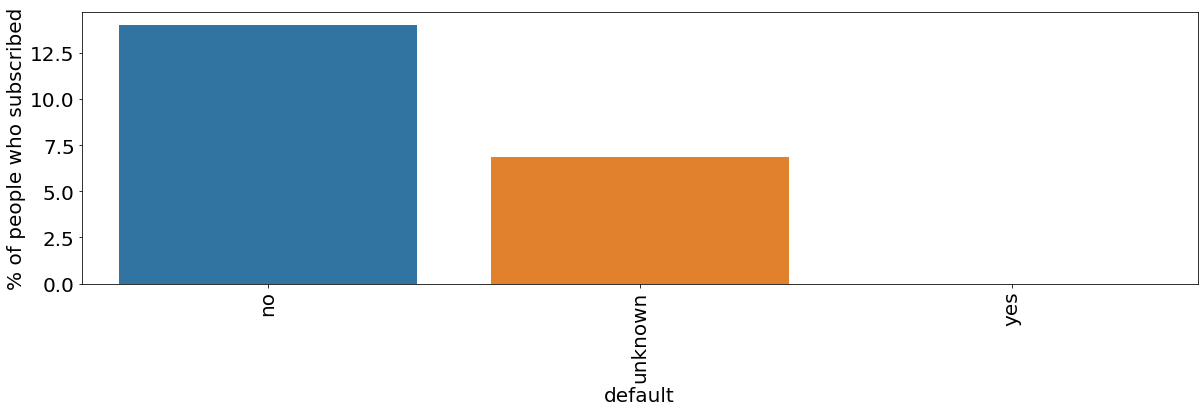

In [154]:
column = 'default'

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

contact


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


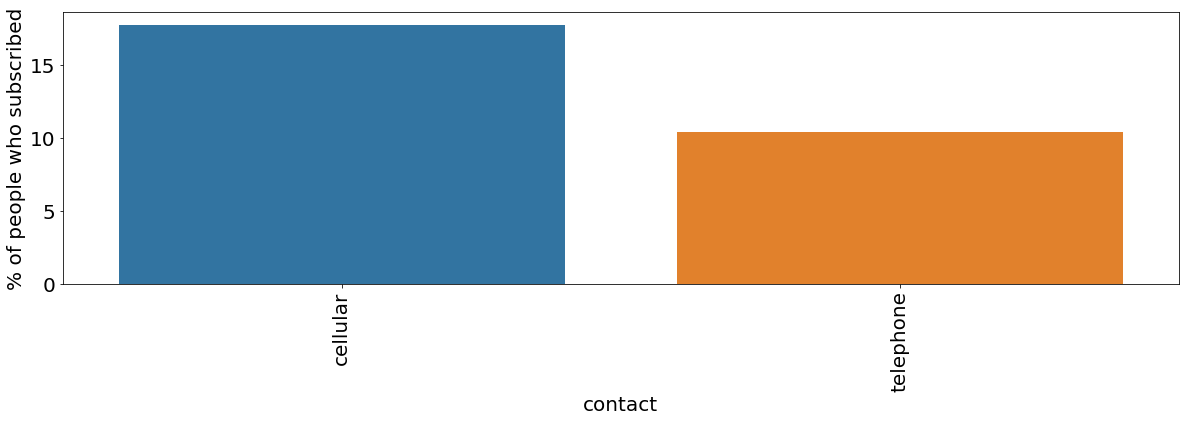

In [52]:
column = data.columns[7]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

month


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


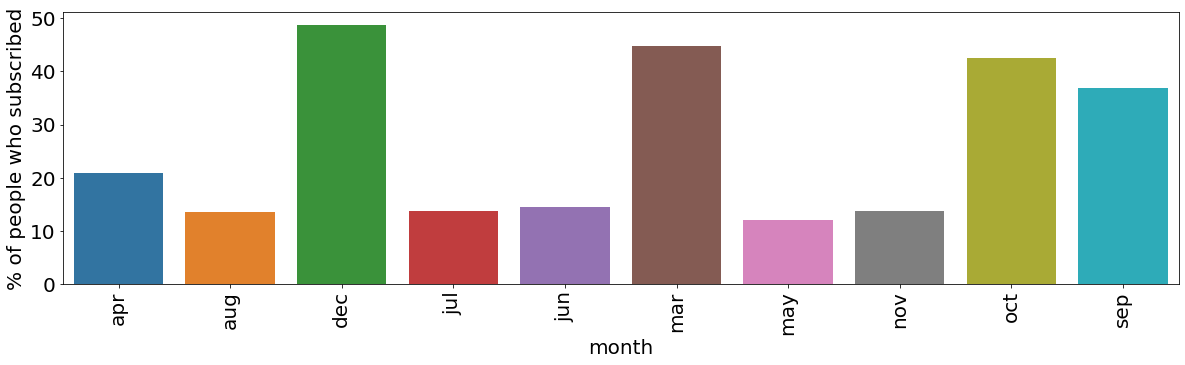

In [53]:
column = data.columns[8]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

nr.employed


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


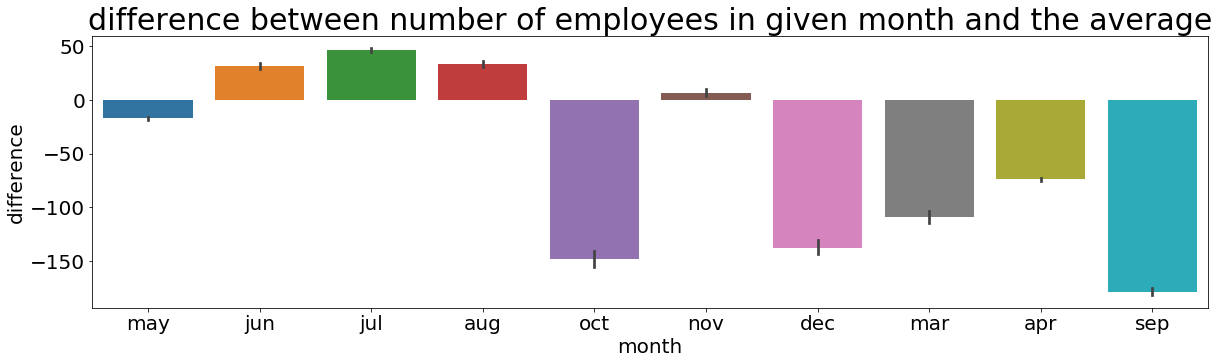

In [54]:
column = data.columns[19]
print(column)

df = data[['month', column]]

avg = data[column].mean()

df[column] = df[column].apply(lambda x: x - avg)

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, y = column, x = 'month')
# plt.plot(df['month'], df[column])
# plt.xticks(rotation = 90)
plt.title('difference between number of employees in given month and the average', fontsize = 30)
plt.ylabel('difference', fontsize = 20)
plt.xlabel('month', fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

the fact that in some months the campaign was more successful might have been caused by the fact that in those months employement was higher or lower because it was the same as in the other months

duration


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


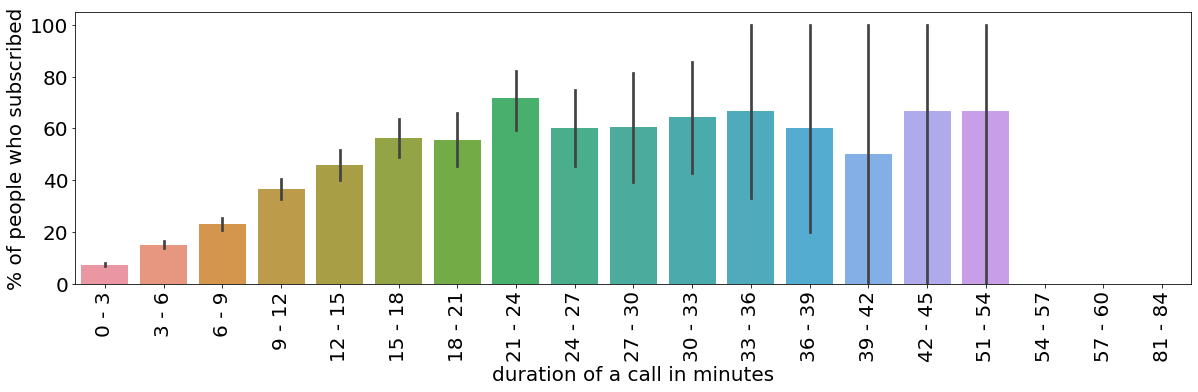

In [55]:
column = data.columns[10]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

# assign range into a value. 
# For example if value = 3 and range_length = 5 then this function returns string '0 - 5'.
# if value = 6 and range_length = 5 then this function returns string '5 - 10'.
def assign_range(value, range_length):
    i = 0
    while i < value:
        i += range_length
    if i > 0:
        return f'{(i - range_length) // 60} - {i // 60}'
    else:
        return f'{i // 60} - {(i + range_length) // 60}'
    
df[column] = df[column].apply(lambda x: assign_range(x, 180))

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel('duration of a call in minutes', fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

campaign


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


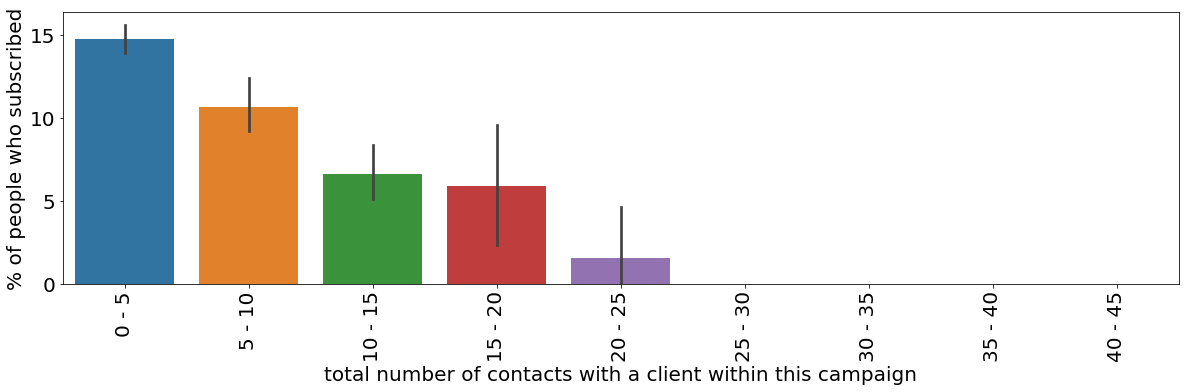

In [56]:
column = data.columns[11]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

# assign range into a value. 
# For example if value = 3 and range_length = 5 then this function returns string '0 - 5'.
# if value = 6 and range_length = 5 then this function returns string '5 - 10'.
def assign_range(value, range_length):
    i = 0
    while i < value:
        i += range_length
    if i > 0:
        return f'{i - range_length} - {i}'
    else:
        return f'{i} - {i + range_length}'
    
df[column] = df[column].apply(lambda x: assign_range(x, 5))

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel('total number of contacts with a client within this campaign', fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

pdays


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


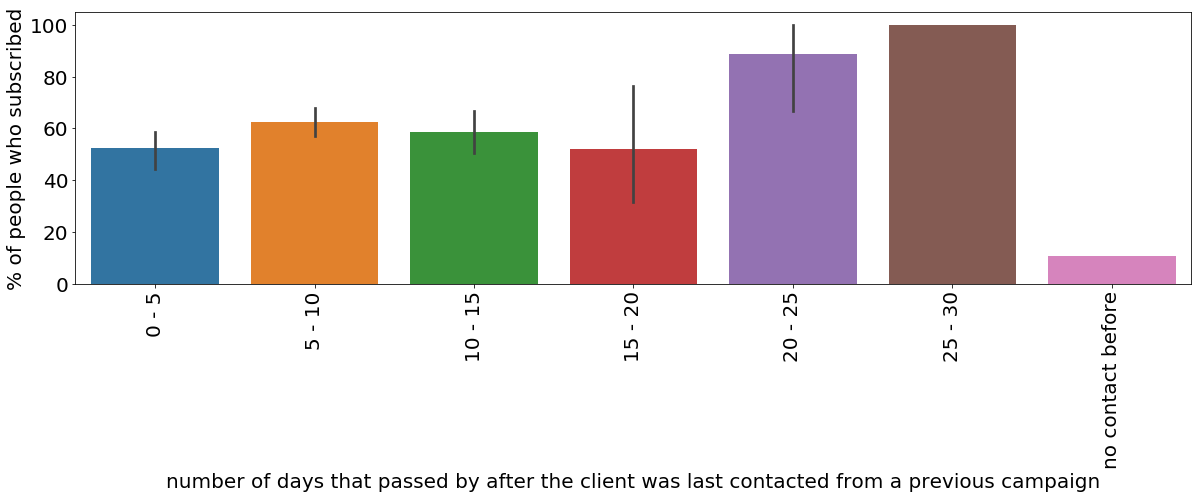

In [57]:
column = data.columns[12]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

# assign range into a value. 
# For example if value = 3 and range_length = 5 then this function returns string '0 - 5'.
# if value = 6 and range_length = 5 then this function returns string '5 - 10'.
def assign_range(value, range_length):
    if value == 999:
        return 'no contact before'
    
    i = 0
    while i < value:
        i += range_length
    if i > 0:
        return f'{i - range_length} - {i}'
    else:
        return f'{i} - {i + range_length}'
    
df[column] = df[column].apply(lambda x: assign_range(x, 5))

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel('number of days that passed by after the client was last contacted from a previous campaign', fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

previous


c:\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


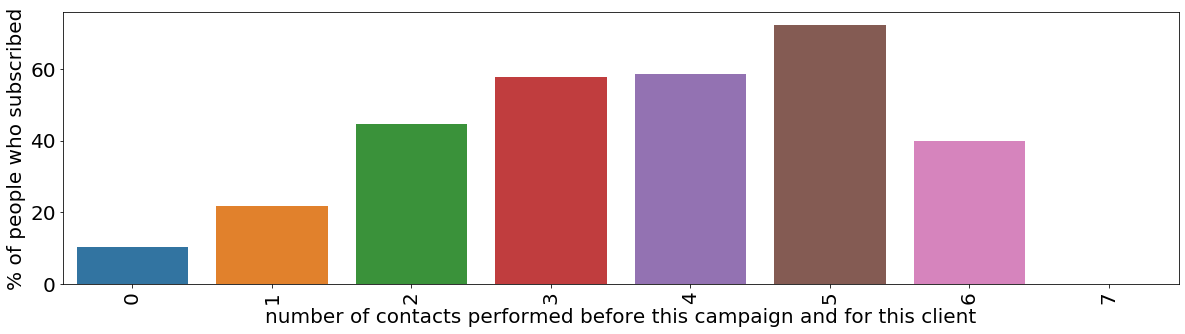

In [58]:
column = data.columns[13]
print(column)

df = data[['y', column]]
df.loc[:, 'y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df.loc[:, 'y'] = df['y'].apply(lambda x: x * 100)

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel('number of contacts performed before this campaign and for this client', fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

poutcome


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


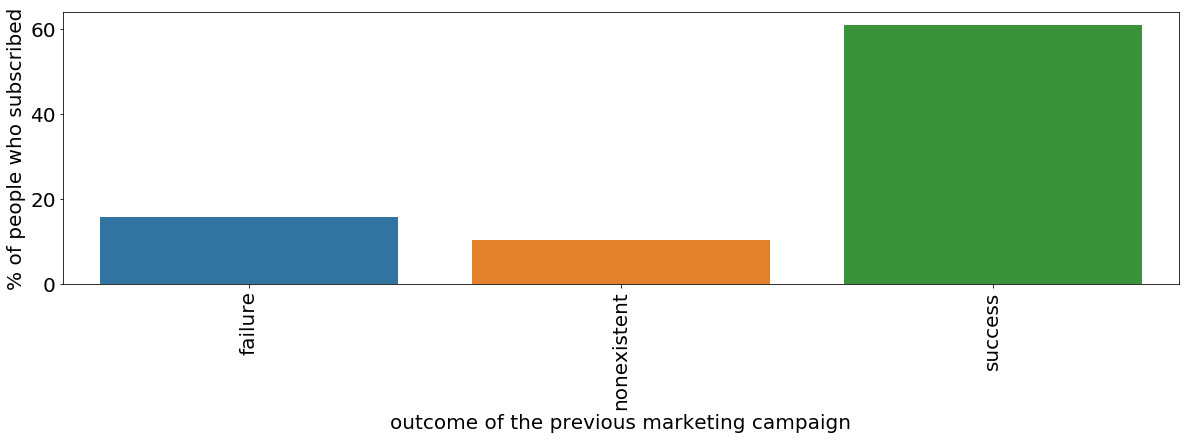

In [59]:
column = data.columns[14]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel('outcome of the previous marketing campaign', fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

emp.var.rate


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


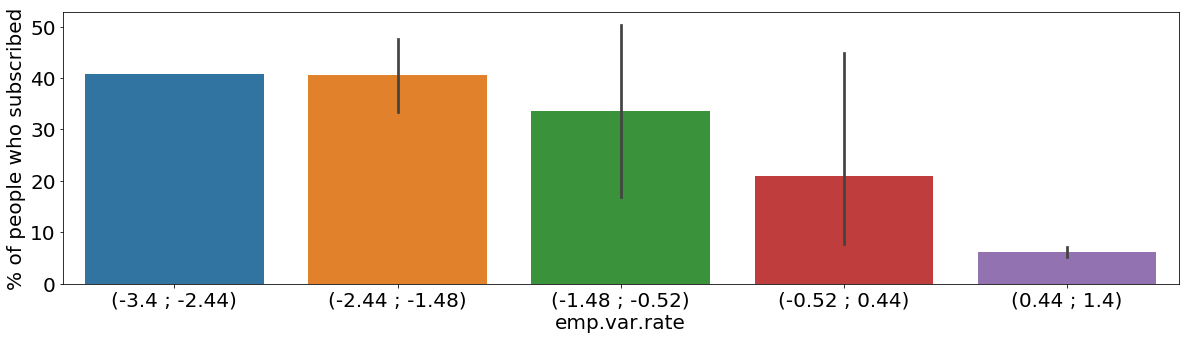

In [60]:
column = data.columns[15]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

# assign range into a value. 
# For example if value = 3 and range_length = 5 then this function returns string '0 - 5'.
# if value = 6 and range_length = 5 then this function returns string '5 - 10'.
def assign_range(value, min_value, range_length):
    i = min_value
    while i < value:
        i += range_length
    if i > 0:
        return f'({round(i - range_length, 2)} ; {round(i, 2)})'
    else:
        return f'({round(i, 2)} ; {round(i + range_length, 2)})'
    
df[column] = df[column].apply(lambda x: assign_range(x, df[column].min(), (df[column].max() - df[column].min()) / 5))

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
# plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

cons.price.idx


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


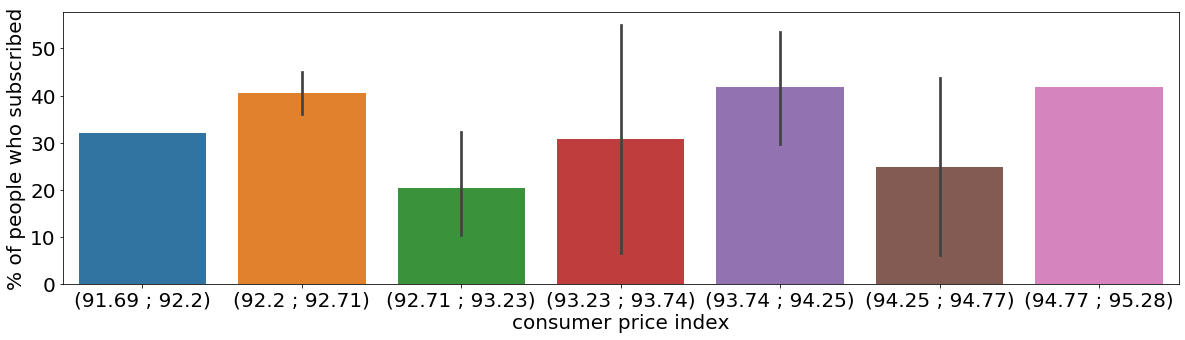

In [61]:
column = data.columns[16]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

# assign range into a value. 
# For example if value = 3 and range_length = 5 then this function returns string '0 - 5'.
# if value = 6 and range_length = 5 then this function returns string '5 - 10'.
def assign_range(value, min_value, range_length):
    i = min_value
    while i < value:
        i += range_length
    if i > 0:
        return f'({round(i - range_length, 2)} ; {round(i, 2)})'
    else:
        return f'({round(i, 2)} ; {round(i + range_length, 2)})'
    
df[column] = df[column].apply(lambda x: assign_range(x, df[column].min(), (df[column].max() - df[column].min()) / 5))

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
# plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel('consumer price index', fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

cons.conf.idx


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


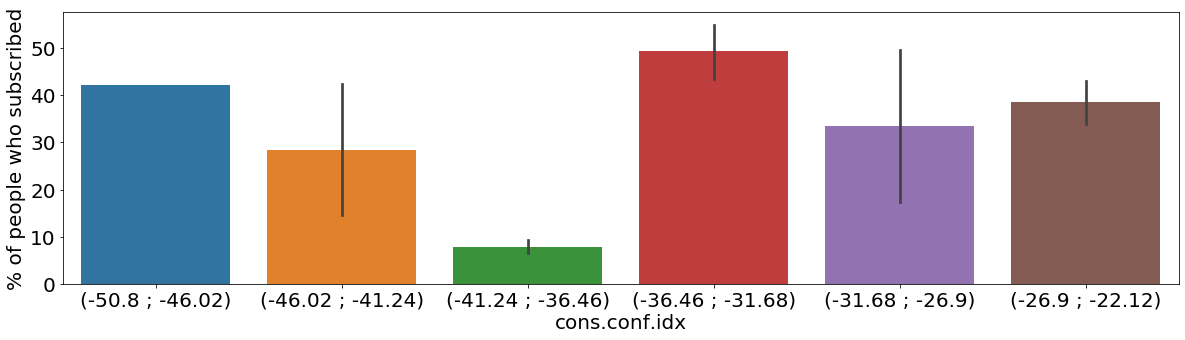

In [62]:
column = data.columns[17]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

# assign range into a value. 
# For example if value = 3 and range_length = 5 then this function returns string '0 - 5'.
# if value = 6 and range_length = 5 then this function returns string '5 - 10'.
def assign_range(value, min_value, range_length):
    i = min_value
    while i < value:
        i += range_length
    if i > 0:
        return f'({round(i - range_length, 2)} ; {round(i, 2)})'
    else:
        return f'({round(i, 2)} ; {round(i + range_length, 2)})'
    
df[column] = df[column].apply(lambda x: assign_range(x, df[column].min(), (df[column].max() - df[column].min()) / 5))

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
# plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

euribor3m


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


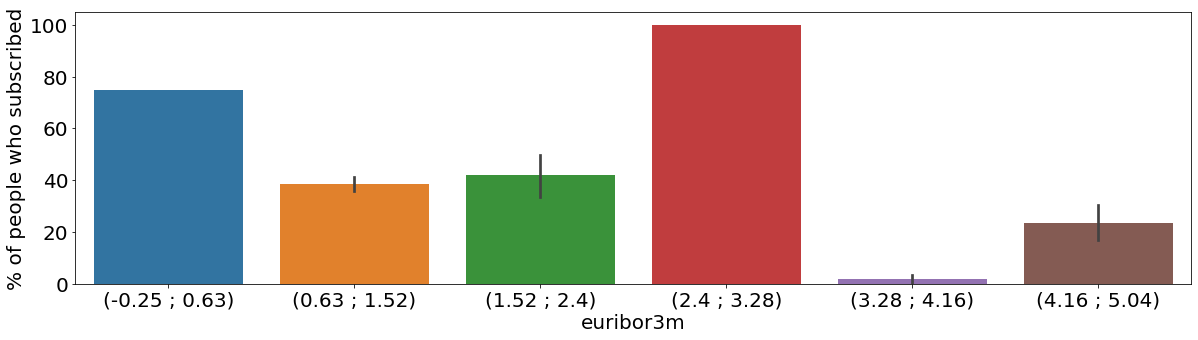

In [63]:
column = data.columns[18]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

# assign range into a value. 
# For example if value = 3 and range_length = 5 then this function returns string '0 - 5'.
# if value = 6 and range_length = 5 then this function returns string '5 - 10'.
def assign_range(value, min_value, range_length):
    i = min_value
    while i < value:
        i += range_length
    if i > 0:
        return f'({round(i - range_length, 2)} ; {round(i, 2)})'
    else:
        return f'({round(i, 2)} ; {round(i + range_length, 2)})'
    
df[column] = df[column].apply(lambda x: assign_range(x, df[column].min(), (df[column].max() - df[column].min()) / 5))

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
# plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

nr.employed


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


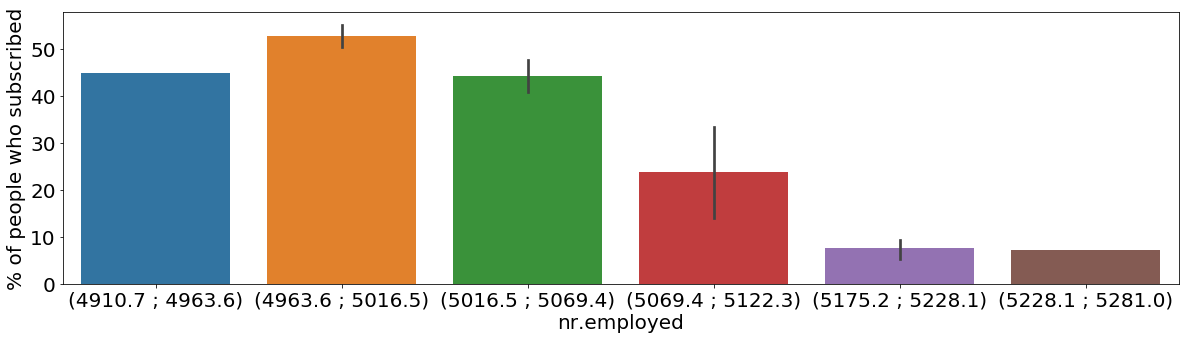

In [64]:
column = data.columns[19]
print(column)

df = data[['y', column]]
df['y'] = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
df = df.groupby(column).mean().reset_index()
df['y'] = df['y'].apply(lambda x: x * 100)

# assign range into a value. 
# For example if value = 3 and range_length = 5 then this function returns string '0 - 5'.
# if value = 6 and range_length = 5 then this function returns string '5 - 10'.
def assign_range(value, min_value, range_length):
    i = min_value
    while i < value:
        i += range_length
    if i > 0:
        return f'({round(i - range_length, 2)} ; {round(i, 2)})'
    else:
        return f'({round(i, 2)} ; {round(i + range_length, 2)})'
    
df[column] = df[column].apply(lambda x: assign_range(x, df[column].min(), (df[column].max() - df[column].min()) / 5))

fig, ax = plt.subplots(figsize = (20, 5))
sns.barplot(data = df, x = column, y = 'y')
# plt.xticks(rotation = 90)
plt.ylabel('% of people who subscribed', fontsize = 20)
plt.xlabel(column, fontsize = 20)
ax.tick_params(axis='both', labelsize = 20)

# machine learning

In [74]:
data = pd.read_csv('bank_data_prediction_task.csv', index_col = 0)

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'test_control_flag'],
      dtype='object')

In [68]:
data.test_control_flag.unique()

array(['campaign group', 'control group'], dtype=object)

## use mix of categorical and continuous variables with one hot encoding

I think that for columns with binary values like 'default', 'housing', 'loan', 'contactedBefore' I don't need to use one hot encoding but for now I will use it because that is simpler

In [75]:
def prepare_data(number_of_clusters, campaign_flag = True):
    """
    number_of_clusters argument indicates into how many clusters we want to divide our dataset where y = 0. 
    We do this because there is there is a lot of rows where y = 0 and few rows where y = 1. In each dataset
    we will have all rows where y = 1. 
    
    Argument campaign_flag indicate if we want to take only rows where test_control_flag == 'campaign group'.
    We need to take only those rows for training and evaluating a model. If we want to check how many clients
    interested in a campaign we can find using a ready model then we can take also rows where 
    test_control_flag == 'control group'
    """
    
    if campaign_flag:
        df = data[data.test_control_flag == 'campaign group']
    else:
        df = data.copy()
        df['campaign'] = data[['test_control_flag', 'campaign']].apply(lambda x: 0 if x['test_control_flag'] == 'control group' else x['campaign'], axis = 1)
        df['contact'] = data[['test_control_flag', 'contact']].apply(lambda x: 'cellular' if x['test_control_flag'] == 'control group' else x['contact'], axis = 1)
        

    # I am not sure if columns 'marital' and 'contact' will have significant impact on model's predictions
    x = df[[
        'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
        'contact', 'campaign', 'pdays', 'previous', 'poutcome', 'nr.employed'
    ]]

    y = df['y']
    
    x['contactedBefore'] = x['pdays'].apply(lambda x: 'yes' if x != '999' else 'no')
    x = x.drop('pdays', axis = 1)
    
    x_categorical = x.drop(['age', 'previous', 'campaign', 'nr.employed'], axis = 1).values
    x_continuous = x[['age', 'previous', 'campaign', 'nr.employed']].values
    
    # one hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    x_categorical = onehot_encoder.fit_transform(x_categorical)

    # normalization
    normalLayer = tf.keras.layers.Normalization(axis=None)
    normalLayer.adapt(x_continuous)
    x_continuous = normalLayer(x_continuous).numpy()
    
    y = y.apply(lambda x: 1 if x == 'yes' else 0).values
    
    # divide dataset where y = 0 into multiple smaller datasets
    # x_categorical_list[i], x_continuous_list[i] and y_list[i] will contain all rows from the dataset where y = 1
    # plus some part of rows where y = 0
    x_categorical_list = []
    x_continuous_list = []
    y_list = []

    zero_indexes = np.where(y == 0)[0]
    one_indexes = np.where(y == 1)[0]

    for i in range(number_of_clusters):
        if i != number_of_clusters - 1:
            zero_indexes_cluster = zero_indexes[i * (len(zero_indexes) // number_of_clusters) : (i + 1) * (len(zero_indexes) // number_of_clusters)]
        else:
            zero_indexes_cluster = zero_indexes[i * (len(zero_indexes) // number_of_clusters) : ]

        indexes = np.concatenate((zero_indexes_cluster, one_indexes))

        x_categorical_list.append(x_categorical[indexes])
        x_continuous_list.append(x_continuous[indexes])

        y_list.append(y[indexes])
        
    # shuffle samples
    for i in range(number_of_clusters):
        indexes = [j for j in range(len(y_list[i]))]
        random.shuffle(indexes)
        
        x_categorical_list[i] = np.array([x_categorical_list[i][index] for index in indexes])
        x_continuous_list[i] = np.array([x_continuous_list[i][index] for index in indexes])
        y_list[i] = np.array([y_list[i][index] for index in indexes])
        
    return x_categorical_list, x_continuous_list, y_list

In [76]:
x_categorical_list, x_continuous_list, y_list = prepare_data(3)

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
i = 0
print(x_categorical_list[i].shape)
print(x_continuous_list[i].shape)
print(y_list[i].shape)

(7148, 39)
(7148, 4)
(7148,)


In [6]:
# compare number of ones with number of zeros in y
i = 2
y = y_list[i]
len(y[y == 1]) / len(y[y == 0])

0.532590051457976

In [6]:
# model which takes as an input both categorical and continuous x variables. At first one neural network takes as an input
# encoded categorical x variables, then output of that network is concatenated with the continuous x variables and this is
# an input to the next neural network

class Model(tf.keras.layers.Layer):
    def __init__(
        self,
        categorical_no_neurons, # list with number of neurons for each layer of categorical input
        categorical_activations, # list with activation functions for each layer of categorical input
        continuous_no_neurons, # list with number of neurons for each layer of continuous input
        continuous_activations, # list with activation functions for each layer of continuous input
        output_shape
    ):
        super().__init__()
        
        # layers for categorical input
        self.categoricalLayers = []
        for no_neurons, activation in zip(categorical_no_neurons, categorical_activations):
            self.categoricalLayers.append(tf.keras.layers.Dense(no_neurons, activation = activation))
        
        # layers for continuous input
        self.continuousLayers = []
        for no_neurons, activation in zip(continuous_no_neurons, continuous_activations):
            self.continuousLayers.append(tf.keras.layers.Dense(no_neurons, activation = activation))
            
        self.continuousLayers.append(tf.keras.layers.Dense(output_shape, activation = 'softmax'))
        
    # @tf.function
    def call(self, x_categorical, x_continuous):
        """
        x_categorical.shape = (batch_size, no_categorical_features)
        x_continuous.shape = (batch_size, no_continuous_features)
        
        x_categorical is an input with categorical variables which are already encoded
        with use of for example one hot encoding
        
        x_continuous is an input with continuous variables
        """
        # make sure that data types are correct
        x_categorical = tf.cast(x_categorical, tf.float32)
        x_continuous = tf.cast(x_continuous, tf.float32)
        
        for layer in self.categoricalLayers:
            x_categorical = layer(x_categorical)
            
        # x_categorical.shape = (batch_size, categorical_no_neurons[-1])
        
        # concatenate output from categoricalLayers with an input with continuous variables
        x = tf.concat([x_categorical, x_continuous], axis = 1)
        
        # x.shape = (batch_size, categorical_no_neurons[-1] + no_continuous_features)
        
        for layer in self.continuousLayers:
            x = layer(x)
            
        return x

In [165]:
# # test if we can calculate gradients

# model = Model()

# with tf.GradientTape() as tape:
#     output = model(x_encoded, x_continuous)
    
# variables = model.trainable_variables
# gradients = tape.gradient(output, variables)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [21]:
# # testing calculating loss

# model = Model(
#     categorical_no_neurons = [30], # list with number of neurons for each layer of categorical input
#     categorical_activations = ['relu'], # list with activation functions for each layer of categorical input
#     continuous_no_neurons = [100, 200, 100], # list with number of neurons for each layer of continuous input
#     continuous_activations = ['relu', 'relu', 'relu'], # list with activation functions for each layer of continuous input
#     output_shape = 2
# )
# pred = model(x_categorical_list[0], x_continuous_list[0])

# print(loss_object(y_list[0], pred))

tf.Tensor(0.6849109, shape=(), dtype=float32)


In [8]:
# @tf.function
def train_step(
    x_categorical,
    x_continuous,
    y,
    model,
    loss_function, 
    optimizer
):
    
    # make sure that the types are correct
    x_categorical = tf.cast(x_categorical, tf.float32)
    x_continuous = tf.cast(x_continuous, tf.float32)
    y = tf.cast(y, tf.float32)
    
    batch_loss = 0
    
    with tf.GradientTape() as tape:
        prediction = model(x_categorical, x_continuous)
        loss = loss_function(y, prediction)
        
        batch_loss += loss
            
    variables = model.trainable_variables
    gradients = tape.gradient(batch_loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [68]:
# # testing train_step

# batch_number = 0
# batch_size = 10

# x_categorical_batch = x_categorical[batch_number * batch_size : (batch_number + 1) * batch_size, :]
# x_continuous_batch = x_continuous[batch_number * batch_size : (batch_number + 1) * batch_size, :]
# y_batch = y[batch_number * batch_size : (batch_number + 1) * batch_size]

# model = Model(
#     categorical_no_neurons = [30], # list with number of neurons for each layer of categorical input
#     categorical_activations = ['relu'], # list with activation functions for each layer of categorical input
#     continuous_no_neurons = [100, 200, 100], # list with number of neurons for each layer of continuous input
#     continuous_activations = ['relu', 'relu', 'relu'], # list with activation functions for each layer of continuous input
#     output_shape = 2
# )

# train_step(
#     x_categorical_batch,
#     x_continuous_batch,
#     y_batch,
#     model,
#     loss_function, 
#     optimizer
# )

In [9]:
# Training the model

epochs = 10
batch_size = 40

# create different models for each dataset
models = [
    Model(
        categorical_no_neurons = [30], # list with number of neurons for each layer of categorical input
        categorical_activations = ['relu'], # list with activation functions for each layer of categorical input
        continuous_no_neurons = [100, 200, 100], # list with number of neurons for each layer of continuous input
        continuous_activations = ['relu', 'relu', 'relu'], # list with activation functions for each layer of continuous input
        output_shape = 2
    )
    for i in range(len(y_list))
]

for model, x_categorical, x_continuous, y in zip(
    models,
    x_categorical_list,
    x_continuous_list,
    y_list
):
    for epoch in range(epochs):
        stime = time()
        total_loss = 0
        for batch_number in range(len(y) // batch_size):
            x_categorical_batch = x_categorical[batch_number * batch_size : (batch_number + 1) * batch_size, :]
            x_continuous_batch = x_continuous[batch_number * batch_size : (batch_number + 1) * batch_size, :]
            y_batch = y[batch_number * batch_size : (batch_number + 1) * batch_size]
            y_batch = np.expand_dims(y_batch, 1)

            batch_loss = train_step(
                x_categorical_batch,
                x_continuous_batch,
                y_batch,
                model,
                loss_object, 
                optimizer
            )

            total_loss += batch_loss

            # print(f'Batch number: {batch_number}, Loss: {batch_loss / batch_size}, Time per batch: {(time() - stime) / (batch_number + 1)}')
            if batch_loss / batch_size < 0.001:
                break
                
        if batch_loss / batch_size < 0.001:
            break
        
#     print(f'Epoch: {epoch + 1}, Loss: {total_loss / ((batch_number + 1) * batch_size)}, Time per epoch: {time() - stime}\n')
    # break
    # if batch_loss / batch_size < 0.9:
    #     break

In [10]:
# model which take an average from predictions from all models trained on different subsets of the main dataset
def finalModel(models, x_categorical, x_continuous):
    # models = [models[i] for i in [0,2]]
    
    preds = []
    for model in models:
        pred = model(x_categorical, x_continuous).numpy()
        preds.append(pred)
        
    return np.mean(preds, axis = 0)

In [11]:
# predictions using average from different models
def evaluateFinalModel(models, x_categorical, x_continuous, y, threshold):
    pred = finalModel(models, x_categorical, x_continuous)
    pred = np.array([0 if p[0] > threshold else 1 for p in pred])
    
    # calculating true positives, true negatives, false negatives and false positives
    tp = len(np.where((y == pred) & (pred == 1))[0])
    tn = len(np.where((y == pred) & (pred == 0))[0])
    fp = len(np.where((y != pred) & (pred == 1))[0])
    fn = len(np.where((y != pred) & (pred == 0))[0])
    
    return tp, tn, fp, fn

In [12]:
# predictions from 1 model
def evaluateSingleModel(model, x_categorical, x_continuous, y, threshold):
    pred = model(x_categorical, x_continuous)
    pred = np.array([0 if p[0] > threshold else 1 for p in pred])
    
    # calculating true positives, true negatives, false negatives and false positives
    tp = len(np.where((y == pred) & (pred == 1))[0])
    tn = len(np.where((y == pred) & (pred == 0))[0])
    fp = len(np.where((y != pred) & (pred == 1))[0])
    fn = len(np.where((y != pred) & (pred == 0))[0])
    
    return tp, tn, fp, fn

In [13]:
# evaluating final model

x_categorical, x_continuous, y = prepare_data(1)
x_categorical = x_categorical[0]
x_continuous = x_continuous[0]
y = y[0]
threshold = 0.5

tp, tn, fp, fn = evaluateFinalModel(models, x_categorical, x_continuous, y, threshold)

# check precision
precision = tp / (tp + fp)

# check recall
recall = tp / (tp + fn)

print('recall: ', recall)
print('precision: ', precision)

# confusion matrix
print('confusion matrix: \n',
    np.array([
        [tp, fn], 
        [fp, tn]
    ])
)

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


recall:  0.5611916264090178
precision:  0.2336182336182336
confusion matrix: 
 [[1394 1090]
 [4573 9419]]


In [41]:
# evaluating a single model

i = 1
model = models[i]
x_categorical = x_categorical_list[i]
x_continuous = x_continuous_list[i]
y = y_list[i]
threshold = 0.5

tp, tn, fp, fn = evaluateSingleModel(model, x_categorical, x_continuous, y, threshold)

# check precision
try:
    precision = tp / (tp + fp)
except:
    precision = 'undefined'
    
# check recall
try:
    recall = tp / (tp + fn)
except:
    recall = 'undefined'

print('recall: ', recall)
print('precision: ', precision)

# confusion matrix
print('confusion matrix: \n',
    np.array([
        [tp, fn], 
        [fp, tn]
    ])
)

recall:  0.0
precision:  undefined
confusion matrix: 
 [[   0 2484]
 [   0 4664]]


In [19]:
# check accuracy
len(np.where(y == pred)[0]) / len(y)

NameError: name 'pred' is not defined

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


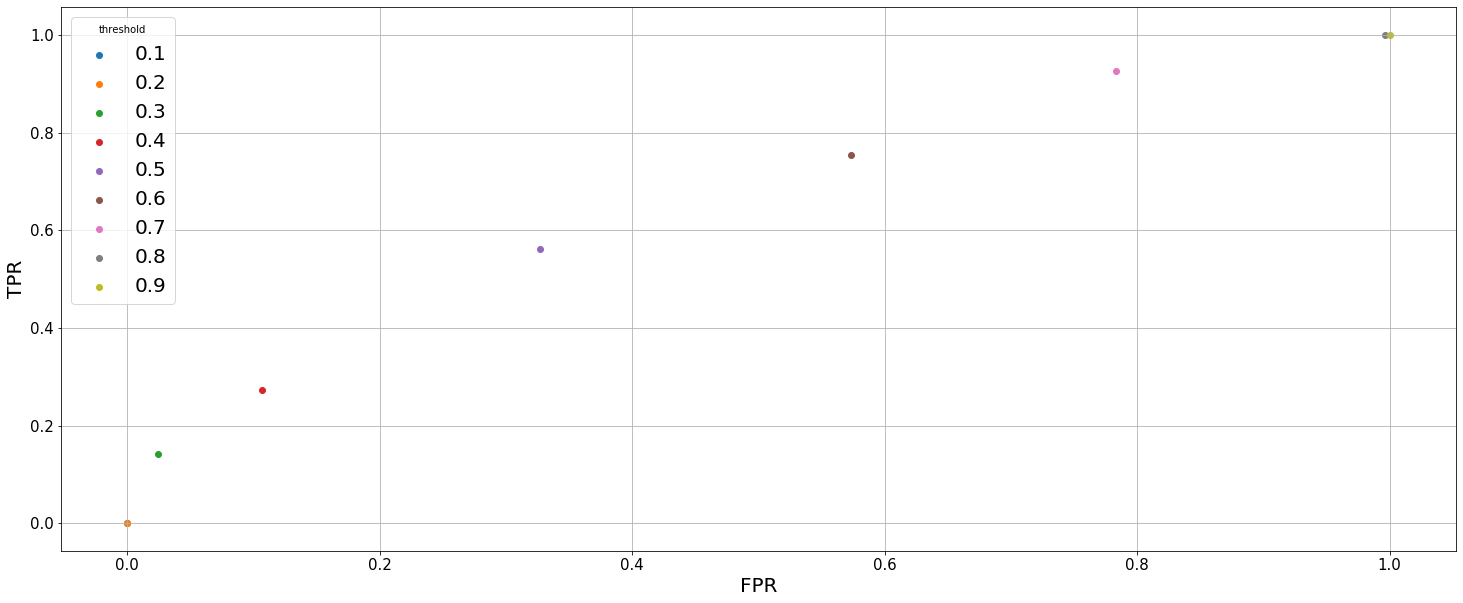

In [14]:
# ROC graph

x_categorical, x_continuous, y = prepare_data(1)
x_categorical = x_categorical[0]
x_continuous = x_continuous[0]
y = y[0]

tpr_list = []
fpr_list = []
thresholds = [i / 10 for i in range(1,10)]

for threshold in thresholds:
    tp, tn, fp, fn = evaluateFinalModel(models, x_categorical, x_continuous, y, threshold)

    # true positive rate. Number of true positives divided by total number of positives
    tpr = tp / (tp + fn) 
    # false positive rate. Number of false positives divided by total number of negatives.
    fpr = fp / (fp + tn)
    
    tpr_list.append(tpr)
    fpr_list.append(fpr)

    
fig, ax = plt.subplots(figsize = (25, 10))
for i in range(len(thresholds)):
    ax.scatter(fpr_list[i], tpr_list[i], label = thresholds[i])
    
ax.legend(title = 'threshold', fontsize = 20)

ax.set_xlabel('FPR', fontsize = 20)
ax.set_ylabel('TPR', fontsize = 20)

ax.tick_params(labelsize = 15)

ax.grid(True)
plt.show()

In [15]:
auc = np.trapz(y = tpr_list, x = fpr_list)
print('AUC: ', auc)

AUC:  0.6582355347523176


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


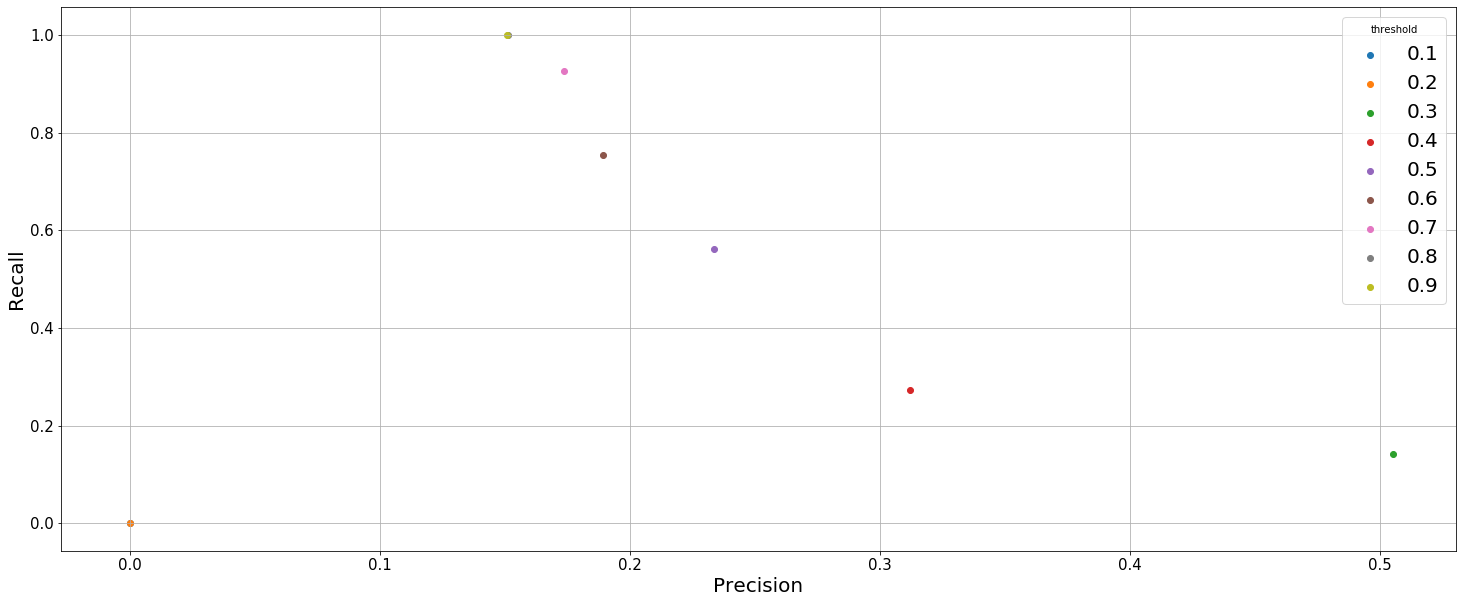

In [16]:
# precision vs recall

x_categorical, x_continuous, y = prepare_data(1)
x_categorical = x_categorical[0]
x_continuous = x_continuous[0]
y = y[0]

recall_list = []
prec_list = []
thresholds = [i / 10 for i in range(1,10)]

for threshold in thresholds:
    tp, tn, fp, fn = evaluateFinalModel(models, x_categorical, x_continuous, y, threshold)

    # recall
    recall = tp / (tp + fn) 
    
    # precision
    try:
        precision = tp / (tp + fp)
    except:
        precision = 0
    
    recall_list.append(recall)
    prec_list.append(precision)

    
fig, ax = plt.subplots(figsize = (25, 10))
for i in range(len(thresholds)):
    ax.scatter(prec_list[i], recall_list[i], label = thresholds[i])
    
ax.legend(title = 'threshold', fontsize = 20)

ax.set_xlabel('Precision', fontsize = 20)
ax.set_ylabel('Recall', fontsize = 20)

ax.tick_params(labelsize = 15)

ax.grid(True)
plt.show()

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


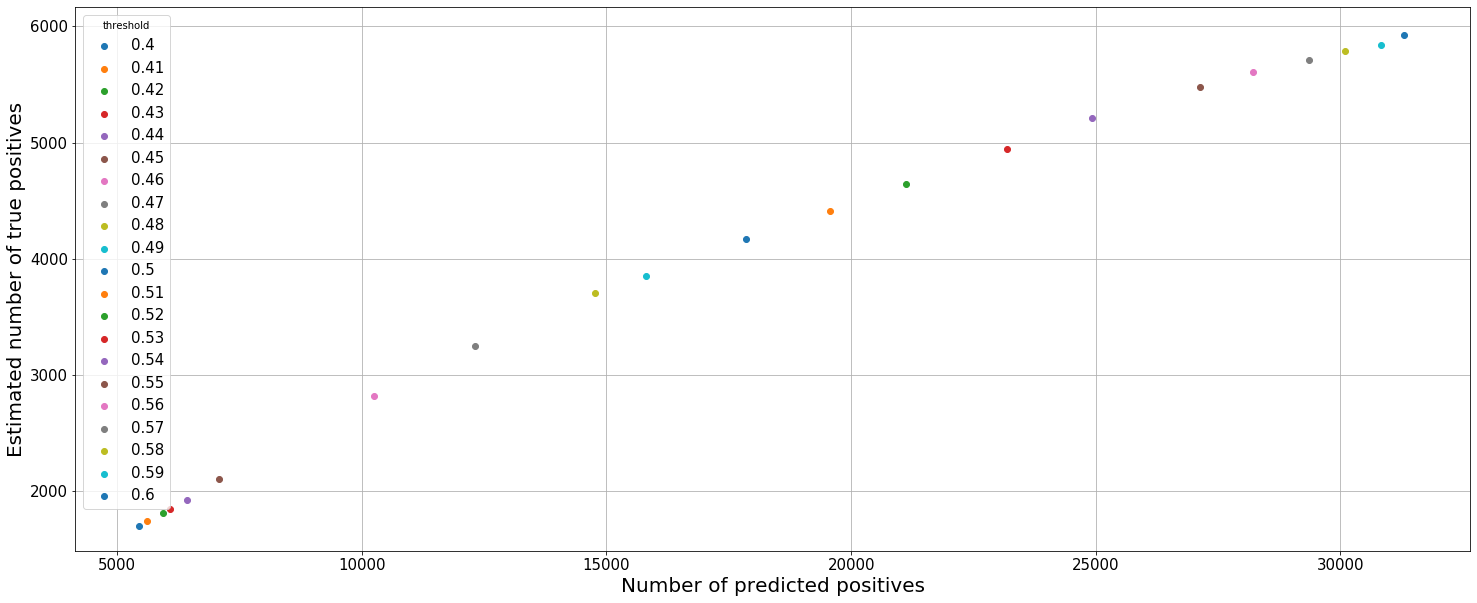

In [72]:
# calculate precisions for different thresholds

thresholds = np.arange(0.4, 0.61, 0.01)
precision_list = []

x_categorical, x_continuous, y = prepare_data(1)
x_categorical = x_categorical[0]
x_continuous = x_continuous[0]
y = y[0]

for threshold in thresholds:
    tp, tn, fp, fn = evaluateFinalModel(models, x_categorical, x_continuous, y, threshold)
    
    # precision
    try:
        precision = tp / (tp + fp)
    except:
        precision = 0
    
    precision_list.append(precision)


# calculate number of predicted positives of a whole dataset (for both campaign and control group)
# we will also calculate estimated number of true positives (= number of predicted positives * precision)

x_categorical_list, x_continuous_list, y_list = prepare_data(1, campaign_flag = False)
x_categorical = x_categorical_list[0]
x_continuous = x_continuous_list[0]
y = y_list[0]

# pp_list is a list with number of predicted positives for different thresholds
pp_list = []

# tp_list is a list with estimated numbers of true positives for different thresholds. 
# estimated number of true positives = number of predicted positives * precision
tp_list = []

for i, threshold in enumerate(thresholds):
    tp, tn, fp, fn = evaluateFinalModel(models, x_categorical, x_continuous, y, threshold)

    # pp indicates nuber of predicted positives 
    pp = tp + fp
    pp_list.append(pp)
    tp_list.append(pp * precision_list[i])

    
fig, ax = plt.subplots(figsize = (25, 10))
for i in range(len(thresholds)):
    ax.scatter(pp_list[i], tp_list[i], label = round(thresholds[i], 2))
    
ax.legend(title = 'threshold', fontsize = 15)

ax.set_xlabel('Number of predicted positives', fontsize = 20)
ax.set_ylabel('Estimated number of true positives', fontsize = 20)

ax.tick_params(labelsize = 15)

ax.grid(True)
plt.show()

## evaluating lift

In [22]:
x_categorical_list, x_continuous_list, y_list = prepare_data(1, campaign_flag = False)
x_categorical = x_categorical_list[0]
x_continuous = x_continuous_list[0]
y = y_list[0]

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
x_categorical.shape

(41188, 39)

In [66]:
pred = finalModel(models, x_categorical, x_continuous)
threshold = 0.5
pred = np.array([0 if p[0] > threshold else 1 for p in pred])

In [67]:
len(pred[pred == 1])

17844

So our model says that there is almost 18000 clients for who our campaign will be successful but we know that our model has 25% of precision. So if we contact those 18000 clients we should have 25% accuracy.